In [8]:
import torch
import numpy as np
from torch import nn
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle as RectPatch

from ccn import Literal, Constraint, ConstraintsGroup, ConstraintsModule, ConstraintsLayer

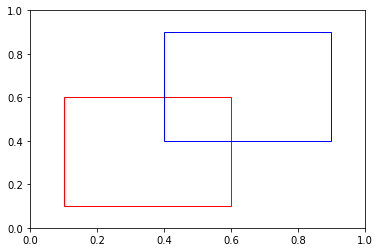

In [9]:
class Rectangle:
    def __init__(self, x0, x1, y0, y1):
        self.lower = np.array([x0, y0])
        self.higher = np.array([x1, y1])
        
    def inside(self, x, y):
        point = np.array([x, y])
        return ((self.lower <= point) * (point <= self.higher)).sum().item() == 2
    
    def plot(self, ax, edgecolor = 'blue'):
        dim = self.higher - self.lower
        ax.add_patch(RectPatch((self.lower[0], self.lower[1]), dim[0], dim[1], fill = False, edgecolor = edgecolor))
    
rect0 = Rectangle(0.1, 0.6, 0.1, 0.6)
rect1 = Rectangle(0.4, 0.9, 0.4, 0.9)

def draw_rectangles(ax, rect0, rect1):
    plt.axis([0., 1., 0., 1.])
    rect0.plot(ax, 'red')
    rect1.plot(ax)

fig, ax = plt.subplots()
draw_rectangles(ax, rect0, rect1)
plt.show()

In [10]:
class RectanglesDataset(Dataset):
    def __init__(self, count, r0, r1):
        super(RectanglesDataset, self).__init__()
        self.r0 = r0
        self.r1 = r1

        self.values = [torch.rand((2,)) for i in range(count)]
        self.labels = [self.correct(x, y) for (x, y) in self.values]

    def correct(self, x, y):
        small = self.r0.inside(x, y)
        big = small or self.r1.inside(x, y)
        return torch.tensor([1. if v else 0. for v in [small, big]])

    def __len__(self):
        return len(self.values)  

    def __getitem__(self, index):
        return self.values[index], self.labels[index]

In [11]:
points = 10000
train_data = RectanglesDataset(points, rect0, rect1)
test_data = RectanglesDataset(points // 10, rect0, rect1)

train_dataloader = DataLoader(train_data, batch_size = 64)
test_dataloader = DataLoader(test_data, batch_size = 64)

In [12]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.linear = nn.Sequential(
            nn.Linear(2, 4),
            nn.Tanh(),
            nn.Linear(4, 2),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.linear(x)
        return x

model = NeuralNetwork()
print(model)

NeuralNetwork(
  (linear): Sequential(
    (0): Linear(in_features=2, out_features=4, bias=True)
    (1): Tanh()
    (2): Linear(in_features=4, out_features=2, bias=True)
    (3): Sigmoid()
  )
)


### Training and testing

In [13]:
clayer = ConstraintsLayer(ConstraintsGroup([Constraint('1 :- 0')]), 2)
loss_fn = nn.BCELoss()
learning_rate = 1e-2
#optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate, betas = (0.9, 0.999))

In [14]:
def train(dataloader, model, clayer, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):   
        # Compute prediction error
        pred = model(X)
        pred = clayer(pred, goal=y)
        loss = loss_fn(pred, y)
        
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f} [{current:>5d}/{size:>5d}]")

In [15]:
def test(dataloader, model, clayer):
    size = len(dataloader.dataset)
    model.eval()
    test_loss, correct_small, correct_big = 0, 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            pred = clayer(pred)
            test_loss += loss_fn(pred, y).item()
            correct_small += (torch.where(pred[:, 0] > 0.5, 1., 0.) == y[:, 0]).sum().item()
            correct_big += (torch.where(pred[:, 1] > 0.5, 1., 0.) == y[:, 1]).sum().item()
    test_loss /= size
    correct_small /= size
    correct_big /= size
    print(f"Test Error: \n Accuracy: {(100*correct_small):>0.1f}%, {(100*correct_big):>0.1f}%, Avg loss: {test_loss:>8f} \n")

### Training and testing on the Rectangles dataset

In [16]:
epochs = 100
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, clayer, loss_fn, optimizer)
    test(test_dataloader, model, clayer)
print("Done!")

Epoch 1
-------------------------------
loss: 0.749608 [    0/10000]
loss: 0.563806 [ 6400/10000]
Test Error: 
 Accuracy: 70.3%, 51.0%, Avg loss: 0.009520 

Epoch 2
-------------------------------
loss: 0.613118 [    0/10000]
loss: 0.564203 [ 6400/10000]
Test Error: 
 Accuracy: 70.0%, 57.3%, Avg loss: 0.009452 

Epoch 3
-------------------------------
loss: 0.612114 [    0/10000]
loss: 0.563147 [ 6400/10000]
Test Error: 
 Accuracy: 70.0%, 57.8%, Avg loss: 0.009410 

Epoch 4
-------------------------------
loss: 0.610065 [    0/10000]
loss: 0.560932 [ 6400/10000]
Test Error: 
 Accuracy: 70.0%, 57.8%, Avg loss: 0.009363 

Epoch 5
-------------------------------
loss: 0.607757 [    0/10000]
loss: 0.557336 [ 6400/10000]
Test Error: 
 Accuracy: 70.0%, 56.6%, Avg loss: 0.009301 

Epoch 6
-------------------------------
loss: 0.604369 [    0/10000]
loss: 0.552364 [ 6400/10000]
Test Error: 
 Accuracy: 70.2%, 55.9%, Avg loss: 0.009225 

Epoch 7
-------------------------------
loss: 0.600360 [  

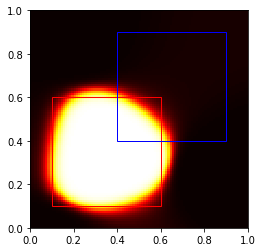

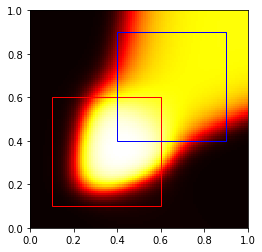

In [17]:
xs = np.arange(0., 1., 0.01, dtype = "float32")
ys = np.arange(0., 1., 0.01, dtype = "float32")
grid = np.array([(x, y) for x in xs for y in ys])
grid = torch.from_numpy(grid)

probs = model(grid)
#probs = clayer(probs)

small = probs[:, 0].reshape(len(xs), len(ys)).detach().numpy()
large = probs[:, 1].reshape(len(xs), len(ys)).detach().numpy()

fig, ax = plt.subplots()
ax.imshow(small, cmap='hot', interpolation='nearest', extent=(0., 1., 0., 1.), origin='lower')
draw_rectangles(ax, rect0, rect1)
plt.show()

fig, ax = plt.subplots()
ax.imshow(large, cmap='hot', interpolation='nearest', extent=(0., 1., 0., 1.), origin='lower')
draw_rectangles(ax, rect0, rect1)
plt.show()

In [18]:
print(small.max())
print(large.max())

0.9999987
0.9792939
